## **import**

In [1]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from category_encoders import TargetEncoder
import os
import warnings
import pandas as pd
import geopandas as gpd

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

## **데이터 불러오기**

In [309]:
input_dir = '../Database/'
file_train = 'train.csv'
file_test = 'submission.csv'
train_data = pd.read_csv(os.path.join(input_dir, file_train))
test_data = pd.read_csv(os.path.join(input_dir, file_test))

## EDA

In [310]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [311]:
def plot_top_categories_conversion_rate(df, category_col, target_col, top_n=10):
    # 각 범주별로 target_col의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율을 계산합니다.
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택합니다.
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    # 상위 N개 범주의 데이터를 선택합니다.
    top_conversion_rates = conversion_rates.loc[top_categories]

    # 시각화: 상위 N개 범주의 전환율을 바 차트로 시각화합니다.
    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(8, 3))


    plt.title(f'Top {top_n} {category_col} Conversion Rate')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')

    # x축 레이블 회전
    plt.xticks(rotation=45)

    # 범례 설정
    plt.legend(title='Is Converted', labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()



In [312]:
# 데이터프레임의 열 데이터 타입을 확인하고, 'object' 또는 'category' 타입인 열의 이름을 리스트로 저장
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object' or train_data[col].dtype.name == 'category']

# 범주형 열의 이름을 출력
(categorical_columns)

['customer_country',
 'business_unit',
 'customer_type',
 'enterprise',
 'customer_job',
 'inquiry_type',
 'product_category',
 'product_subcategory',
 'product_modelname',
 'customer_country.1',
 'customer_position',
 'response_corporate',
 'expected_timeline',
 'business_area',
 'business_subarea']

## **0. bant_submit**
결측치 없고 unique 값 : 0/0.25/0.5/0.75/1.00

In [313]:
train_data['bant_submit'].value_counts(),test_data['bant_submit'].value_counts()

(bant_submit
 0.50    17192
 1.00    17061
 0.25    12852
 0.75    11681
 0.00      513
 Name: count, dtype: int64,
 bant_submit
 1.00    2070
 0.25    1522
 0.50     667
 0.75     545
 0.00     467
 Name: count, dtype: int64)


## **1. customer_country와 customer_country.1**

In [314]:
# 두 열 유사도 분석
filtered_data = train_data[train_data['customer_country']!=train_data['customer_country.1']]
display(filtered_data[['customer_country','customer_country.1']])

# customer_country.1는 중복되는 값이므로 drop
train_data = train_data.drop(columns='customer_country.1')
test_data = test_data.drop(columns='customer_country.1')

,customer_country,customer_country.1
106,NaN,NaN
121,NaN,NaN
142,NaN,NaN
949,NaN,NaN
1005,NaN,NaN
...,...,...
59118,NaN,NaN
59119,NaN,NaN
59196,NaN,NaN
59252,NaN,NaN


In [315]:
na_rows= train_data[train_data['customer_country'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.01656014435319314


In [316]:
train_data['customer_country'] = train_data['customer_country'].str.split('/').str[-1].str.strip()
test_data['customer_country'] = test_data['customer_country'].str.split('/').str[-1].str.strip()
train_data['customer_country'] = train_data['customer_country'].str.lower()
test_data['customer_country'] = test_data['customer_country'].str.lower()

In [317]:
country_mapping = {
    'u.a.e': 'united arab emirates',
    'uae dubai': 'united arab emirates',
    ' india': 'india',
    'türkiye': 'turkey',
    'us': 'united states',
    'usa': 'united states',
    ' united states' : 'united states',
    'u.k': 'united kingdom',
    'uk': 'united kingdom',
    'brasil': 'brazil',
    'ha noi': 'vietnam',
    'south korea': 'korea',
    'republic of korea': 'korea',
    's. korea': 'korea',
    'czech': 'czech republic',
    'czechia': 'czech republic',
    'macau': 'china',
    'england': 'united kingdom',
    'scotland': 'united kingdom',
    'prc': 'china',
    'mainland china': 'china',
    'france': 'france',
    'french': 'france',
    'paris': 'france',  # 특정 도시를 나라명으로 매핑
    'germany': 'germany',
    'deutschland': 'germany',  # 독일의 독일어 명칭
    'berlin': 'germany',  # 특정 도시를 나라명으로 매핑
    'abu dhabi': 'united arab emirates',  # 특정 도시를 나라명으로 매핑
    'dubai': 'united arab emirates',  # 특정 도시를 나라명으로 매핑
}

# 나라명 표준화 적용
train_data['customer_country'] = train_data['customer_country'].replace(country_mapping)
test_data['customer_country'] = test_data['customer_country'].replace(country_mapping)

In [318]:
# na_rows = train_data[train_data['customer_country'].isna()]
# result = train_data.groupby('response_corporate')['customer_country'].nunique()
# output = result[result <= 2].index

# for index, row in na_rows.iterrows():
#     if row['response_corporate'] in output:
#         replacement_country = train_data.loc[train_data['response_corporate'] == row['response_corporate'], 'customer_country'].iloc[0]
#         train_data.loc[index, 'customer_country'] = replacement_country


In [319]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_country'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, 비율:{len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_country' are in train_data: False
Values in test_data not in train_data: {'233 south beaudry avenue  los angeles ca', 'liberia', 'w126 n7449 flint drive menomonee falls va', '603 heritage drive  mount juliet', 'englewood, co', '5003 lady of the lake dr  raleigh nc', 'nm', 'tx', '3 center plz suite 330 boston, ma 02108', 'fl', 'nj', 'ne'}
number of missing_values : 12, 비율:0.1188118811881188


In [320]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['customer_country'].value_counts()
idx_to_replace = frequency[frequency <= 15].index
train_data['customer_country'] = train_data['customer_country'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['customer_country'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['customer_country'] = test_data['customer_country'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [321]:
# 타겟인코딩
value_counts = train_data['customer_country'].value_counts()
smoothing = 5  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['customer_country'], smoothing=smoothing)
train_data['customer_country'] = encoder.fit_transform(train_data['customer_country'], train_data['is_converted'])
test_data['customer_country'] = encoder.transform(test_data['customer_country'], test_data['is_converted'])

## **2.com_reg_ver_win_rate**
Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산</br>
결측치 -> 0

In [322]:
na_rows= train_data[train_data['com_reg_ver_win_rate'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.7543297526096562


In [323]:
train_data['com_reg_ver_win_rate'] = train_data['com_reg_ver_win_rate'].fillna(0)
test_data['com_reg_ver_win_rate'] = test_data['com_reg_ver_win_rate'].fillna(0)

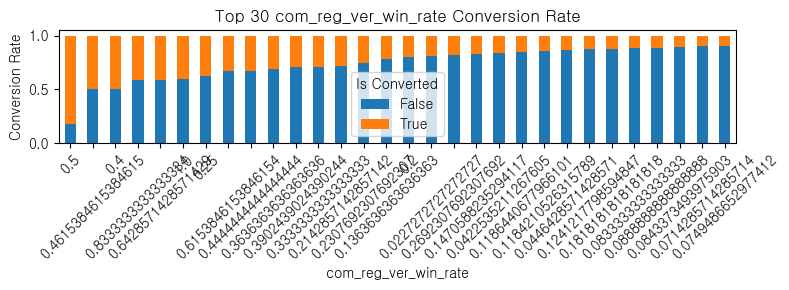

In [324]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['com_reg_ver_win_rate']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

## **3.customer_idx**
:고객의 회사명</br>
결측치 없음. 타겟인코딩

In [325]:
train_data['customer_idx'].nunique(), test_data['customer_idx'].nunique()

(35112, 4069)

In [326]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_idx'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_idx' are in train_data: False
Values in test_data not in train_data: {16384, 1, 4, 8200, 9, 32776, 32779, 24588, 24589, 40973, 8208, 24592, 40976, 32787, 22, 40983, 8219, 30, 36, 8231, 24619, 43, 32813, 32814, 16431, 48, 24620, 8242, 41007, 54, 24632, 8249, 16452, 69, 24644, 8266, 8271, 41043, 16467, 24661, 32857, 16477, 24672, 32866, 24675, 32868, 104, 107, 41070, 16495, 41071, 113, 16497, 24691, 8305, 24687, 32888, 32892, 130, 41094, 136, 16521, 24714, 41098, 24717, 41103, 41108, 24727, 32924, 156, 163, 32931, 166, 167, 41137, 16562, 8372, 24758, 183, 41143, 32952, 8379, 41155, 32964, 16580, 32965, 32968, 32969, 24777, 16587, 204, 203, 205, 41166, 24778, 8401, 24780, 8406, 214, 24795, 41180, 8414, 16609, 16610, 8418, 32996, 8417, 33003, 24814, 16623, 16627, 41214, 24831, 256, 16641, 16645, 33033, 16651, 24844, 33037, 24846, 24848, 41235, 8474, 8475, 33050, 33052, 24862, 8479, 8480, 41247, 16681, 16683, 33072, 41265, 33078, 41273, 41274, 315, 2

In [327]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['customer_idx'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['customer_idx'] = train_data['customer_idx'].replace(idx_to_replace, -1)



# train 데이터의 고유값 추출
unique_train_values = train_data['customer_idx'].unique()
unique_test_values = test_data['customer_idx'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['customer_idx'] = test_data['customer_idx'].apply(lambda x: x if x in unique_train_values else 0)

In [328]:
# 타겟인코딩
value_counts = train_data['customer_idx'].value_counts()
smoothing = 5  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['customer_idx'], smoothing=smoothing)
train_data['customer_idx'] = encoder.fit_transform(train_data['customer_idx'], train_data['is_converted'])
test_data['customer_idx'] = encoder.transform(test_data['customer_idx'], test_data['is_converted'])

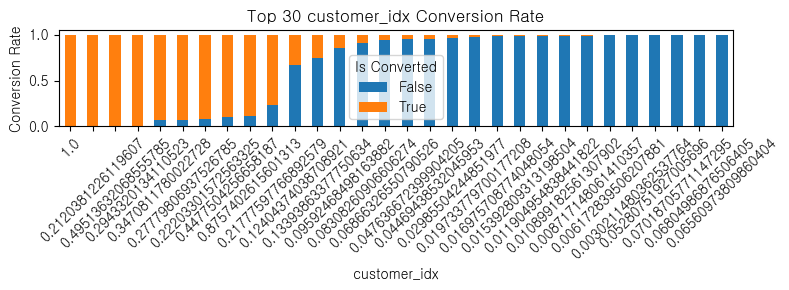

In [329]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_idx']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

## **4.customer_type**
결측치 -> others </br>
열값 -> 공백, 기호 제거

In [330]:
na_rows= train_data[train_data['customer_type'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.7413447107033846


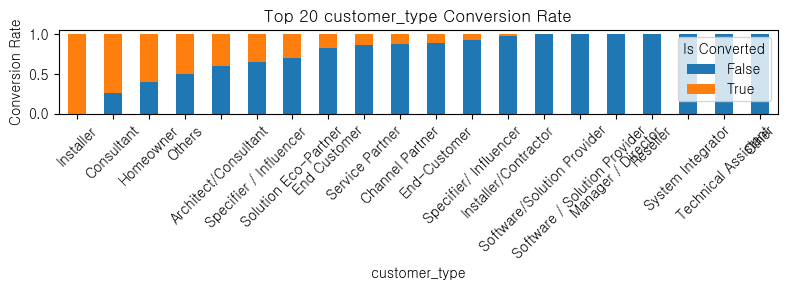

In [331]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_type']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=20)

In [332]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_type'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_type' are in train_data: True


In [333]:
# 텍스트 전처리
train_data['customer_type'] = train_data['customer_type'].replace(r'[\/\.\_\~\-\s]', '', regex=True)
test_data['customer_type'] = test_data['customer_type'].replace(r'[\/\_\.\~\-\s]', '', regex=True)

In [334]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['customer_type'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['customer_type'] = train_data['customer_type'].replace(idx_to_replace, 'other')

unique_train_values = train_data['customer_type'].unique()
unique_test_values = test_data['customer_type'].unique()

# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['customer_type'] = test_data['customer_type'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [335]:
# 타겟인코딩
value_counts = train_data['customer_type'].value_counts()
smoothing = 5  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['customer_type'], smoothing=smoothing)
train_data['customer_type'] = encoder.fit_transform(train_data['customer_type'], train_data['is_converted'])
test_data['customer_type'] = encoder.transform(test_data['customer_type'], test_data['is_converted'])

## **5.historical_existing_cnt**
값 중에 0 이 존재 </br>
결측치 -> 평균 또는 중앙값 

In [336]:
na_rows= train_data[train_data['historical_existing_cnt'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.7680230695289971


In [337]:
# 빈도 확인
train_data['historical_existing_cnt'].value_counts(), test_data['historical_existing_cnt'].value_counts()

(historical_existing_cnt
 4.0       2957
 0.0       1973
 1.0       1967
 19.0      1441
 16.0      1132
           ... 
 404.0        1
 145.0        1
 1394.0       1
 199.0        1
 108.0        1
 Name: count, Length: 136, dtype: int64,
 historical_existing_cnt
 0.0      345
 19.0     142
 16.0     121
 1.0      121
 3.0       94
         ... 
 33.0       1
 179.0      1
 98.0       1
 22.0       1
 23.0       1
 Name: count, Length: 74, dtype: int64)

In [338]:
train_data['historical_existing_cnt'].mean(),train_data['historical_existing_cnt'].median()
test_data['historical_existing_cnt'].mean(),test_data['historical_existing_cnt'].median()

(19.91218377435301, 4.0)

(21.27294117647059, 4.0)

In [339]:
train_data['historical_existing_cnt'] = train_data['historical_existing_cnt'].fillna(train_data['historical_existing_cnt'].median())
test_data['historical_existing_cnt'] = test_data['historical_existing_cnt'].fillna(train_data['historical_existing_cnt'].median())

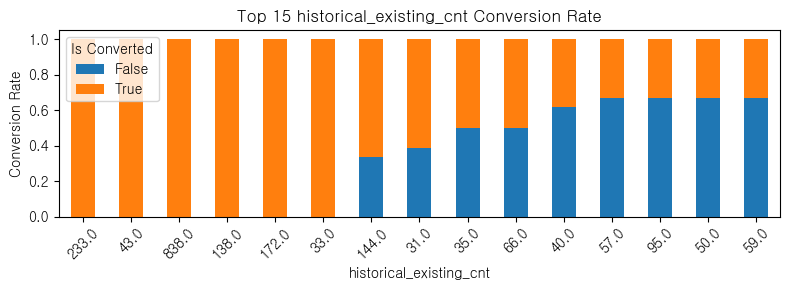

In [340]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['historical_existing_cnt']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=15)

## **6.id_strategic_ver,it_strategic_ver,idit_strategic_ver**
사업영역과 사업부에 해당하는 값이 있는 결측치 대체하고 </br>
나머지는 0

In [341]:
na_rows= train_data[train_data['id_strategic_ver'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['it_strategic_ver'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.9419214489283124
결측치 비율 0.9810958026273631


In [342]:
# id_strategic_ver 열에서 NaN 값이 아닌 행들만 선택
not_nan_data = train_data.dropna(subset=['id_strategic_ver'])
# cleaned_data를 사용하여 business_unit과 business_area로 그룹을 지어 id_strategic_ver의 평균을 계산
grouped_avg = not_nan_data.groupby(['business_unit', 'business_area'])['id_strategic_ver'].mean()
print(grouped_avg)

business_unit  business_area        
ID             corporate / office       1.0
               hotel & accommodation    1.0
Name: id_strategic_ver, dtype: float64


In [343]:
condition = (
    (train_data['id_strategic_ver'].isna()) & 
    (train_data['business_unit'] == 'ID') & 
    ((train_data['business_area'] == 'corporate / office') | (train_data['business_area'] == 'hotel & accommodation'))
)

# 조건에 해당하는 id_strategic_ver 열의 결측치를 1로 대체, 나머지는 0
train_data.loc[condition, 'id_strategic_ver'] = 1
train_data['id_strategic_ver'] = train_data['id_strategic_ver'].fillna(0)


condition = (
    (test_data['id_strategic_ver'].isna()) & 
    (test_data['business_unit'] == 'ID') & 
    ((test_data['business_area'] == 'corporate / office') | (test_data['business_area'] == 'hotel & accommodation'))
)

# 조건에 해당하는 id_strategic_ver 열의 결측치를 1로 대체, 나머지는 0
test_data.loc[condition, 'id_strategic_ver'] = 1
test_data['id_strategic_ver'] = test_data['id_strategic_ver'].fillna(0)

In [344]:
# it_strategic_ver 열에서 NaN 값이 아닌 행들만 선택
cleaned_data = train_data.dropna(subset=['it_strategic_ver'])
# cleaned_data를 사용하여 business_unit과 business_area로 그룹을 지어 it_strategic_ver 평균을 계산
grouped_avg = cleaned_data.groupby(['business_unit', 'business_area'])['it_strategic_ver'].mean()
print(grouped_avg)

business_unit  business_area        
IT             corporate / office       1.0
               hotel & accommodation    1.0
Name: it_strategic_ver, dtype: float64


In [345]:
condition = (
    (train_data['it_strategic_ver'].isna()) & 
    (train_data['business_unit'] == 'IT') & 
    ((train_data['business_area'] == 'corporate / office') | (train_data['business_area'] == 'hotel & accommodation'))
)

# 조건에 해당하는 id_strategic_ver 열의 결측치를 1로 대체, 나머지는 0
train_data.loc[condition, 'it_strategic_ver'] = 1
train_data['it_strategic_ver'] = train_data['it_strategic_ver'].fillna(0)

condition = (
    (test_data['it_strategic_ver'].isna()) & 
    (test_data['business_unit'] == 'IT') & 
    ((test_data['business_area'] == 'corporate / office') | (test_data['business_area'] == 'hotel & accommodation'))
)

# 조건에 해당하는 id_strategic_ver 열의 결측치를 1로 대체, 나머지는 0
test_data.loc[condition, 'it_strategic_ver'] = 1
test_data['it_strategic_ver'] = test_data['it_strategic_ver'].fillna(0)


In [346]:
# id, it 둘중 하나라도 있으면 1 아니면 0으로 idit를 수정
train_data['idit_strategic_ver'] = np.where((train_data['id_strategic_ver'] == 1) | (train_data['it_strategic_ver'] == 1), 1, 0)

test_data['idit_strategic_ver'] = np.where((test_data['id_strategic_ver'] == 1) | (test_data['it_strategic_ver'] == 1), 1, 0)


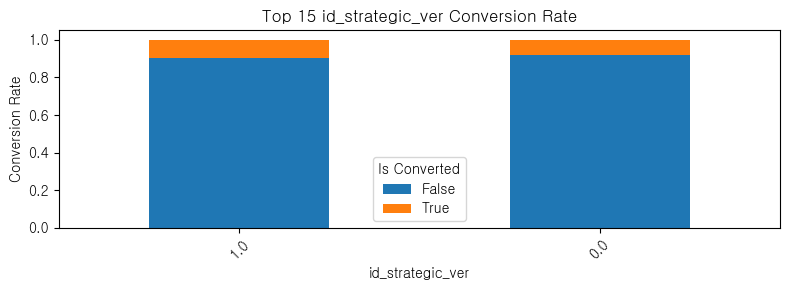

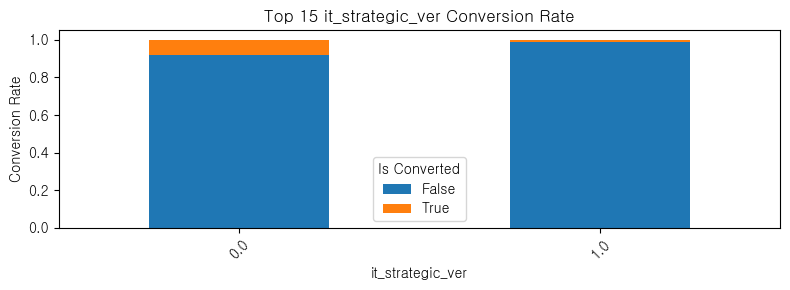

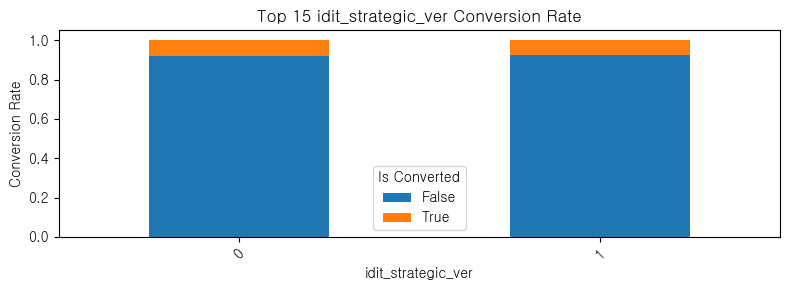

In [347]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['id_strategic_ver','it_strategic_ver','idit_strategic_ver']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=15)

## **7. lead_desc_length**
결측치 없음</br>
scailing 만 진행


In [348]:
train_data['lead_desc_length'].describe()

count    59299.000000
mean        79.271590
std        132.551067
min          1.000000
25%          7.000000
50%         29.000000
75%         92.000000
max       1264.000000
Name: lead_desc_length, dtype: float64

In [349]:
# import numpy as np

# train_data['lead_desc_length'] = np.log(train_data['lead_desc_length'])
# test_data['lead_desc_length'] = np.log(test_data['lead_desc_length'])

In [350]:
# Min-Max 스케일링을 위한 최소값과 최대값 계산
min_value = train_data['lead_desc_length'].min()
max_value = train_data['lead_desc_length'].max()

# Min-Max 스케일링 적용
train_data['lead_desc_length'] = (train_data['lead_desc_length'] - min_value) / (max_value - min_value)
test_data['lead_desc_length'] = (test_data['lead_desc_length'] - min_value) / (max_value - min_value)

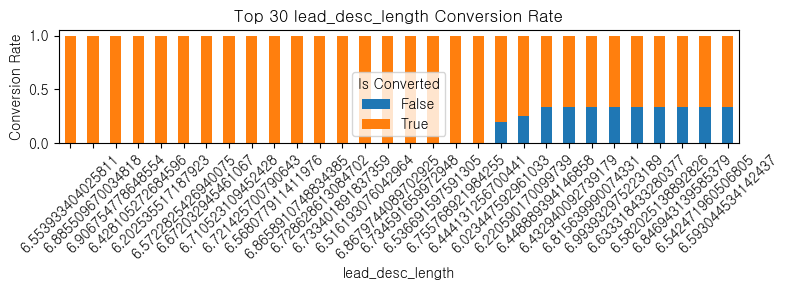

In [351]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['lead_desc_length']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

## **8. customer_job, customer_position**

In [352]:
na_rows= train_data[train_data['customer_job'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['customer_position'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.31590751951972207
결측치 비율 0.0


In [353]:
train_data['customer_job'] = train_data['customer_job'].fillna('none')
test_data['customer_job'] = test_data['customer_job'].fillna('none')

customer_job

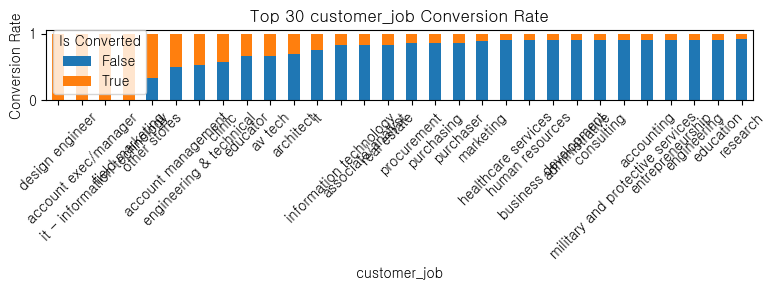

In [354]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_job']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

In [355]:
frequency = train_data['customer_job'].value_counts()
frequency[1:]

customer_job
engineering                       6342
other                             4852
administrative                    3359
education                         2287
sales                             2218
                                  ... 
appliance specialist                 1
av estimator                         1
purchasers                           1
pricing                              1
exhibition / convention center       1
Name: count, Length: 560, dtype: int64

In [356]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_job'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(test_data[column_name].unique())
unique_values_test = set(train_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_job' are in train_data: False
Values in test_data not in train_data: {'design and provide equipment', 'general contractor', 'assist in serving food', 'submitting proposal', 'general manager - project manager', 'sourcing & quoting for end user', 'studio manager', 'display', 'we are in iceland', 'creative director', 'it', 'medical solution provider\u200b', 'property owner', 'sales operations', 'administrative assistant', 'graphic/color art', 'surgery professional\u200b', 'contractor/owner', 'digital signage', 'videowall', 'purchsing', 'development coordinator/procurement', 'sourcing/procurement', 'supplier and installation', 'authorize (you are responsible for making the final decision)', 'chief engineer', 'sourcing / procurement', 'producer/project manager', 'maintenance technician', 'deputy cio', 'product owner', 'director of engineering', 'sales rep', 'commander', 'estimator', 'vendor / reseller', 'design/purchaser', 'owning company', 'equipmen

In [357]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_job'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_job' are in train_data: False
Values in test_data not in train_data: {'k12 school', 'healthcare'}
number of missing_values : 2, 0.047619047619047616


In [358]:
# 'job_1' 열에서 'healthcare'가 포함된 데이터를 찾아 해당 값들을 'healthcare'로 변경
train_data.loc[train_data['customer_job'].str.contains('healthcare', case=False, na=False), 'customer_job'] = 'healthcare'
test_data.loc[test_data['customer_job'].str.contains('healthcare', case=False, na=False), 'customer_job'] = 'healthcare'

In [359]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['customer_job'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['customer_job'] = train_data['customer_job'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['customer_job'].unique()
unique_test_values = test_data['customer_job'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['customer_job'] = test_data['customer_job'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [360]:
# 타겟인코딩
value_counts = train_data['customer_job'].value_counts()
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['customer_job'], smoothing=smoothing)
train_data['customer_job'] = encoder.fit_transform(train_data['customer_job'], train_data['is_converted'])
test_data['customer_job'] = encoder.transform(test_data['customer_job'], test_data['is_converted'])

customer_position

In [361]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'customer_position'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'customer_position' are in train_data: False
Values in test_data not in train_data: {'pgt chemistry'}
number of missing_values : 1, 0.043478260869565216


In [362]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['customer_position'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['customer_position'] = train_data['customer_position'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['customer_position'].unique()
unique_test_values = test_data['customer_position'].unique()
# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['customer_position'] = test_data['customer_position'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [363]:
# 타겟인코딩
value_counts = train_data['customer_position'].value_counts()
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['customer_position'], smoothing=smoothing)
train_data['customer_position'] = encoder.fit_transform(train_data['customer_position'], train_data['is_converted'])
test_data['customer_position'] = encoder.transform(test_data['customer_position'], test_data['is_converted'])

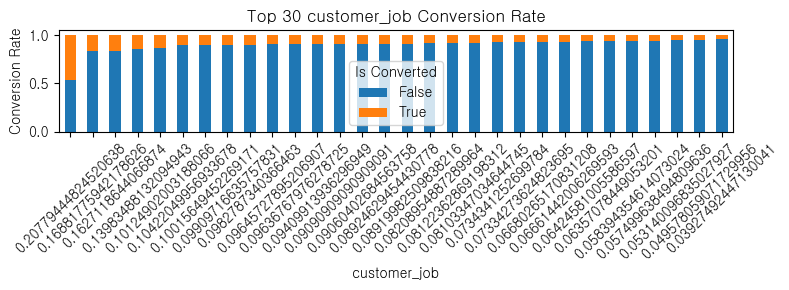

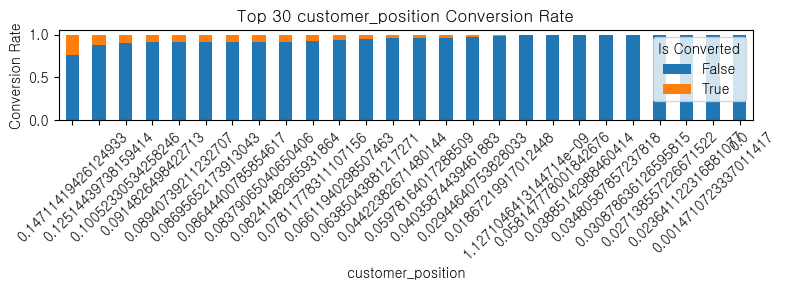

In [364]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_job','customer_position']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

## **9. product_category, product_subcategory,product_modelname,inquiry_type**s


In [365]:
na_rows= train_data[train_data['product_category'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['product_subcategory'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['product_modelname'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['inquiry_type'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.32671714531442353
결측치 비율 0.8442638155786776
결측치 비율 0.8443649977234018
결측치 비율 0.015868733030911145


In [366]:
train_data = train_data.drop(columns=['product_subcategory','product_modelname'])
test_data = test_data.drop(columns=['product_subcategory','product_modelname'])

product_category

In [367]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'product_category'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")
    print(f"number of missing_values : {len(missing_values)}, {len(missing_values)/len(unique_values_test)}")

All test_data unique values of 'product_category' are in train_data: False
Values in test_data not in train_data: {'notebook', 'ess'}
number of missing_values : 2, 0.058823529411764705


In [368]:
train_data['product_category'] = train_data['product_category'].fillna('none')
test_data['product_category'] = test_data['product_category'].fillna('none')

In [369]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['product_category'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['product_category'] = train_data['product_category'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['product_category'].unique()
unique_test_values = test_data['product_category'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['product_category'] = test_data['product_category'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [370]:
#  타겟인코딩
value_counts = train_data['product_category'].value_counts()
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['product_category'], smoothing=smoothing)
train_data['product_category'] = encoder.fit_transform(train_data['product_category'], train_data['is_converted'])
test_data['product_category'] = encoder.transform(test_data['product_category'], test_data['is_converted'])

## inquiry_type

In [371]:
train_data['inquiry_type'] = train_data['inquiry_type'].fillna('none')
test_data['inquiry_type'] = test_data['inquiry_type'].fillna('none')

In [372]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'inquiry_type'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")


All test_data unique values of 'inquiry_type' are in train_data: True


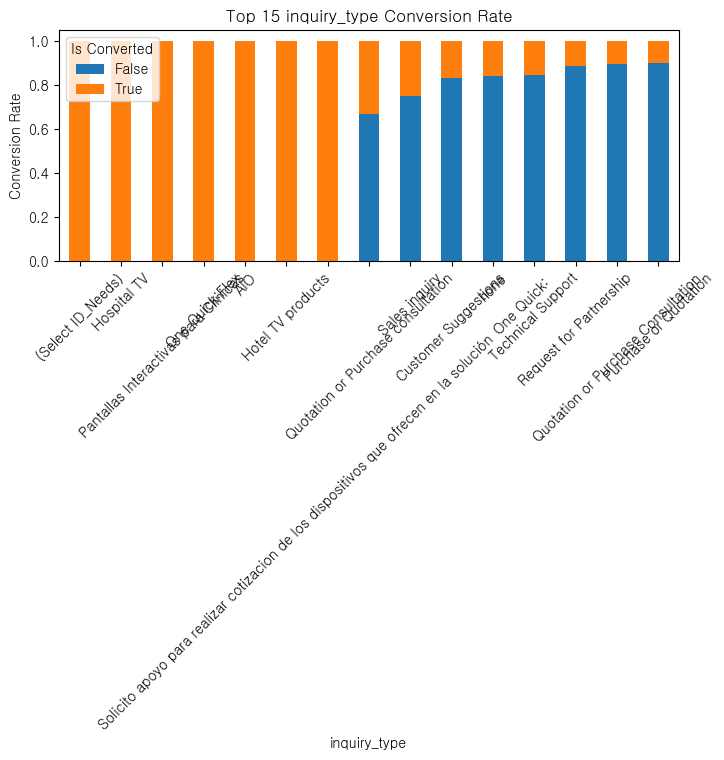

In [373]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['inquiry_type']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=15)

In [374]:
train_data['inquiry_type'] = train_data['inquiry_type'].str.lower()
test_data['inquiry_type'] = test_data['inquiry_type'].str.lower()

In [375]:
train_data['inquiry_type'].nunique()

64

In [376]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['inquiry_type'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['inquiry_type'] = train_data['inquiry_type'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['inquiry_type'].unique()
unique_test_values = test_data['inquiry_type'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['inquiry_type'] = test_data['inquiry_type'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [377]:
#  타겟인코딩
value_counts = train_data['inquiry_type'].value_counts()
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['inquiry_type'], smoothing=smoothing)
train_data['inquiry_type'] = encoder.fit_transform(train_data['inquiry_type'], train_data['is_converted'])
test_data['inquiry_type'] = encoder.transform(test_data['inquiry_type'], test_data['is_converted'])

## **10. response_corporate, expected_timeline,**
response_corporate : 결측치 없음

In [378]:
train_data['response_corporate'].nunique()

53

In [379]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'response_corporate'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")


All test_data unique values of 'response_corporate' are in train_data: True


In [380]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['response_corporate'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train_data['response_corporate'] = train_data['response_corporate'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['response_corporate'].unique()
unique_test_values = test_data['response_corporate'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['response_corporate'] = test_data['response_corporate'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [381]:
from category_encoders import TargetEncoder
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['response_corporate'], smoothing=smoothing)
train_data['response_corporate'] = encoder.fit_transform(train_data['response_corporate'], train_data['is_converted'])
test_data['response_corporate'] = encoder.transform(test_data['response_corporate'], test_data['is_converted'])


expected_timeline

In [382]:
na_rows= train_data[train_data['expected_timeline'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")

결측치 비율 0.5204640887704683


In [383]:
# 텍스트 전처리
train_data['expected_timeline'] = train_data['expected_timeline'].replace(r'[\/\.\_\~\s]', '', regex=True)
test_data['expected_timeline'] = test_data['expected_timeline'].replace(r'[\/\_\.\~\s]', '', regex=True)

In [384]:
train_data['expected_timeline'] = train_data['expected_timeline'].fillna('none')
test_data['expected_timeline'] = test_data['expected_timeline'].fillna('none')

In [385]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'expected_timeline'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")


All test_data unique values of 'expected_timeline' are in train_data: True


In [386]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['expected_timeline'].value_counts()
idx_to_replace = frequency[frequency <= 21].index
train_data['expected_timeline'] = train_data['expected_timeline'].replace(idx_to_replace, 'other')



# train 데이터의 고유값 추출
unique_train_values = train_data['expected_timeline'].unique()
unique_test_values = test_data['expected_timeline'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['expected_timeline'] = test_data['expected_timeline'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [387]:
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['expected_timeline'], smoothing=smoothing)
train_data['expected_timeline'] = encoder.fit_transform(train_data['expected_timeline'], train_data['is_converted'])
test_data['expected_timeline'] = encoder.transform(test_data['expected_timeline'], test_data['is_converted'])

## **11. ver_cus,ver_pro, ver_win_rate_x  ,ver_win_ratio_per_bu**
ver_cus, ver_pro : 결측치 없음  -> 그대로 사용</br>
ver_win_rate_x : 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값</br>
ver_win_ratio_per_bu: 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산

business_unit,business_area 와 ver_win_ratio_per_bu의 관계

In [388]:
na_rows= train_data[train_data['ver_cus'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['ver_pro'].isna()] 
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['ver_win_rate_x'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['ver_win_ratio_per_bu'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")


결측치 비율 0.0
결측치 비율 0.0
결측치 비율 0.6894214067690855
결측치 비율 0.7419180761901549


In [389]:
# business_unit  business_area 에 따라 모두 같은 값을 가지는지
unique_counts = train_data.groupby(['business_unit', 'business_area'])['ver_win_ratio_per_bu'].nunique()
all_same_ver_win_ratio_per_bu = unique_counts == 1

print(all_same_ver_win_ratio_per_bu)

business_unit  business_area                 
AS             corporate / office                 True
               education                          True
               factory                            True
               government department              True
               hospital & health care             True
               hotel & accommodation             False
               power plant / renewable energy     True
               public facility                    True
               residential (home)                 True
               retail                             True
               special purpose                    True
               transportation                    False
ID             corporate / office                 True
               education                          True
               factory                            True
               government department              True
               hospital & health care             True
               hote

In [390]:
# False인 경우, 해당 조합에서 ver_win_ratio_per_bu 값이 nan인지 확인하고 개수를 출력
#결론은 다 nan
for idx, is_same in enumerate(all_same_ver_win_ratio_per_bu):
    if not is_same:
        bu = unique_counts.index[idx][0]
        area = unique_counts.index[idx][1]
        nan_count = train_data[(train_data['business_unit'] == bu) & (train_data['business_area'] == area)]['ver_win_ratio_per_bu'].isna().sum()
        
        print(f"For business_unit '{bu}' and business_area '{area}': {nan_count} rows have nan values in 'ver_win_ratio_per_bu'{len(train_data[(train_data['business_unit'] == bu) & (train_data['business_area'] == area)])}")

For business_unit 'AS' and business_area 'hotel & accommodation': 207 rows have nan values in 'ver_win_ratio_per_bu'207
For business_unit 'AS' and business_area 'transportation': 53 rows have nan values in 'ver_win_ratio_per_bu'53
For business_unit 'IT' and business_area 'corporate / office': 330 rows have nan values in 'ver_win_ratio_per_bu'330
For business_unit 'IT' and business_area 'education': 150 rows have nan values in 'ver_win_ratio_per_bu'150
For business_unit 'IT' and business_area 'factory': 83 rows have nan values in 'ver_win_ratio_per_bu'83
For business_unit 'IT' and business_area 'government department': 49 rows have nan values in 'ver_win_ratio_per_bu'49
For business_unit 'IT' and business_area 'hospital & health care': 895 rows have nan values in 'ver_win_ratio_per_bu'895
For business_unit 'IT' and business_area 'hotel & accommodation': 791 rows have nan values in 'ver_win_ratio_per_bu'791
For business_unit 'IT' and business_area 'power plant / renewable energy': 8 rows

In [391]:
# business_unit  와 business_area 에 따라 나뉘는 값이고 , nan도 퍼져있는 것이 아닌 해당 그룹에 대해서만 nan ->0으로 대체가능
train_data['ver_win_ratio_per_bu'] = train_data['ver_win_ratio_per_bu'].fillna(0)
test_data['ver_win_ratio_per_bu'] = test_data['ver_win_ratio_per_bu'].fillna(0)

ver_win_rate_x 

In [392]:
# 사업영역의 고유 수 와 ver_win_rate_x 의 고유수가 같음
train_data['business_area'].nunique(), train_data['ver_win_rate_x'].nunique()

(12, 12)

In [393]:
na_rows= train_data[train_data['ver_win_rate_x'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['business_area'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")
na_rows= train_data[train_data['business_subarea'].isna()]
print(f"결측치 비율 {len(na_rows)/len(train_data)}")


결측치 비율 0.6894214067690855
결측치 비율 0.6894214067690855
결측치 비율 0.906811244709017


In [394]:
train_data = train_data.drop(columns=['ver_win_rate_x','business_area','business_subarea'])
test_data = test_data.drop(columns=['ver_win_rate_x','business_area','business_subarea'])

## **12. business_unit, enterprise= 결측치 없는 범주형 변수**

In [395]:

# 훈련 데이터와 테스트 데이터에 대한 원-핫 인코딩을 동일하게 적용하기 위해 먼저 결합
combined = pd.concat([train_data['business_unit'],test_data['business_unit']], keys=['train', 'test'])

# 원-핫 인코딩 적용
combined_encoded = pd.get_dummies(combined, columns=['business_unit'])
combined_encoded.columns = ['business_unit_' + col for col in combined_encoded.columns]
# 인코딩된 데이터를 훈련 데이터와 테스트 데이터로 다시 분리
train_encoded = combined_encoded.xs('train')
test_encoded = combined_encoded.xs('test')

# 원-핫 인코딩된 결과를 원래 데이터에 결합하고, 'continent' 열을 제거
train_data = pd.concat([train_data.drop('business_unit', axis=1), train_encoded], axis=1)
test_data = pd.concat([test_data.drop('business_unit', axis=1), test_encoded], axis=1)

In [396]:
# 훈련 데이터와 테스트 데이터에 대한 원-핫 인코딩을 동일하게 적용하기 위해 먼저 결합
combined = pd.concat([train_data['enterprise'],  test_data['enterprise']], keys=['train',  'test'])

# 원-핫 인코딩 적용
combined_encoded = pd.get_dummies(combined, columns=['enterprise'])
combined_encoded.columns = ['enterprise_' + col for col in combined_encoded.columns]
# 인코딩된 데이터를 훈련 데이터와 테스트 데이터로 다시 분리
train_encoded = combined_encoded.xs('train')
test_encoded = combined_encoded.xs('test')

# 원-핫 인코딩된 결과를 원래 데이터에 결합하고, 'continent' 열을 제거
train_data = pd.concat([train_data.drop('enterprise', axis=1), train_encoded], axis=1)
test_data = pd.concat([test_data.drop('enterprise', axis=1), test_encoded], axis=1)

## **13.lead_owner**
결측치없음-> target 인코딩

In [397]:
print(f"고유개수: {train_data['lead_owner'].nunique()}")

고유개수: 984


In [398]:
# 예시 열 이름, 'column_name'을 자신이 확인하고 싶은 열 이름으로 변경하세요
column_name = 'lead_owner'  # 이 예시에서는 'customer_job' 열을 확인합니다

# train_data와 test_data에서 해당 열의 고유값 추출
unique_values_train = set(train_data[column_name].unique())
unique_values_test = set(test_data[column_name].unique())

# test_data의 고유값이 train_data에 있는지 확인
test_values_in_train = unique_values_test.issubset(unique_values_train)

# 결과 출력
print(f"All test_data unique values of '{column_name}' are in train_data: {test_values_in_train}")

# train_data에 없는 test_data의 고유값을 찾아 출력
if not test_values_in_train:
    missing_values = unique_values_test - unique_values_train
    print(f"Values in test_data not in train_data: {missing_values}")


All test_data unique values of 'lead_owner' are in train_data: False
Values in test_data not in train_data: {1024, 1025, 1026, 1028, 1032, 1033, 1046, 1055, 1056, 1058, 1062, 1063, 554, 558, 562, 565, 571, 573, 576, 577, 581, 587, 588, 591, 595, 1108, 127, 135, 136, 723, 727, 731, 733, 734, 735, 736, 747, 748, 749, 750, 751, 752, 766, 769, 772, 773, 777, 308, 821, 313, 315, 316, 828, 320, 323, 327, 331, 844, 336, 850, 347, 353, 866, 867, 356, 868, 874, 373, 377, 379, 892, 907, 908, 911, 922, 427, 960, 962, 963, 965, 966, 969, 978, 999, 1023}


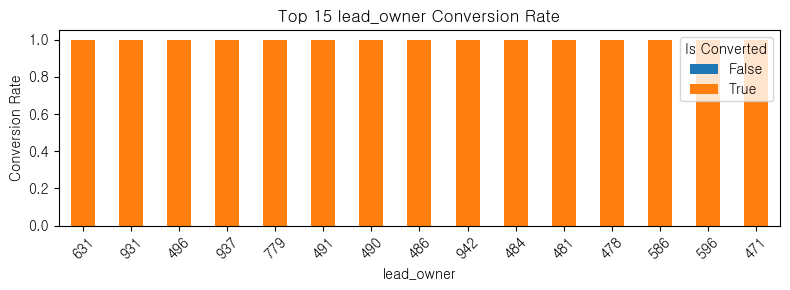

In [399]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['lead_owner']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=15)

In [400]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train_data['lead_owner'].value_counts()
idx_to_replace = frequency[frequency <= 30].index
train_data['lead_owner'] = train_data['lead_owner'].replace(idx_to_replace, 'other_low')



# train 데이터의 고유값 추출
unique_train_values = train_data['lead_owner'].unique()
unique_test_values = test_data['lead_owner'].unique()


# test 데이터에서 train 데이터에 없는 값을 'unknown'으로 대체
test_data['lead_owner'] = test_data['lead_owner'].apply(lambda x: x if x in unique_train_values else 'unknown')

In [401]:
smoothing = 10.0  # 스무딩 값 조정을 통해 결과를 최적화할 수 있습니다.

# 타겟 인코더 초기화 (스무딩 파라미터 적용)
encoder = TargetEncoder(cols=['lead_owner'], smoothing=smoothing)
train_data['lead_owner'] = encoder.fit_transform(train_data['lead_owner'], train_data['is_converted'])
test_data['lead_owner'] = encoder.transform(test_data['lead_owner'], test_data['is_converted'])

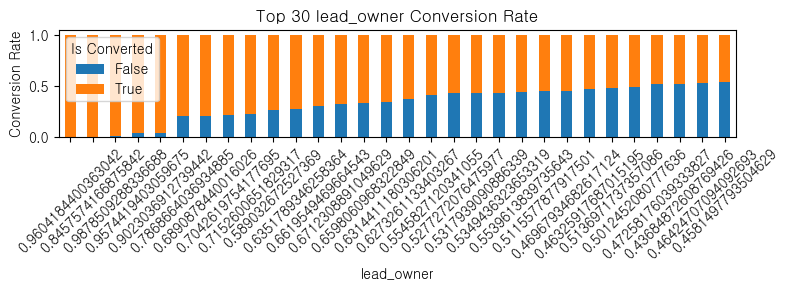

In [402]:
# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['lead_owner']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train_data, col, 'is_converted', top_n=30)

## **14. is_converted**

In [403]:
label_encoder = LabelEncoder()

# 특정 열 라벨 인코딩
train_data['is_converted'] = label_encoder.fit_transform(train_data['is_converted'])


In [404]:
train_data.to_csv('../Database/train_preprocessed.csv', index=False)
test_data.to_csv('../Database/test_preprocessed.csv', index=False)

## 학습하기

In [405]:
train_data_target = pd.DataFrame(train_data['is_converted'])
train_data_feature = train_data.drop(columns='is_converted')

test_data_target = pd.DataFrame(test_data['is_converted'])
test_data_feature = test_data.drop(columns='is_converted')


# 데이터 분할 (0.8:0.2 비율로 분리)
X_train, X_test, y_train, y_test = train_test_split(train_data_feature, train_data_target, test_size=0.2, random_state=42)

In [406]:
from imblearn.over_sampling import SMOTE

# SMOTE를 사용하여 오버샘플링을 적용한 훈련 데이터 생성
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_data_feature, train_data_target)


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score

# Optuna를 위한 목적 함수
def objective(trial):
    # 탐색할 하이퍼파라미터 설정
    param = {
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 12)
    }

    # 모델 생성 및 학습
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='binary')

    return score

# Optuna Study 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적화 결과 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


In [407]:
import optuna
import xgboost as xgb
# Optuna를 위한 목적 함수
def objective(trial):
    # 탐색할 하이퍼파라미터 설정
    param = {
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 1e-1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 12)
    }

    # 모델 생성 및 학습
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='binary')

    return score

# Optuna Study 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# 최적화 결과 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-13 16:05:48,517] A new study created in memory with name: no-name-2cb8a206-0648-4b47-b987-35601bdf5f89
[I 2024-02-13 16:05:52,139] Trial 0 finished with value: 0.8147100424328148 and parameters: {'n_estimators': 422, 'alpha': 0.0003371735113531808, 'gamma': 2.7547042391545122e-06, 'learning_rate': 0.05657984196479375, 'max_depth': 5}. Best is trial 0 with value: 0.8147100424328148.
[I 2024-02-13 16:05:56,809] Trial 1 finished with value: 0.942156862745098 and parameters: {'n_estimators': 332, 'alpha': 0.0002792764330121035, 'gamma': 0.00045387008564147486, 'learning_rate': 0.09506908159476402, 'max_depth': 10}. Best is trial 1 with value: 0.942156862745098.
[I 2024-02-13 16:05:59,860] Trial 2 finished with value: 0.804287045666356 and parameters: {'n_estimators': 282, 'alpha': 0.0003067263837738987, 'gamma': 0.0006643310843232926, 'learning_rate': 0.05460793647058985, 'max_depth': 6}. Best is trial 1 with value: 0.942156862745098.
[I 2024-02-13 16:06:03,679] Trial 3 finished

Number of finished trials: 30
Best trial: {'n_estimators': 401, 'alpha': 0.07807795950051662, 'gamma': 5.890502452025174e-05, 'learning_rate': 0.2306347275897469, 'max_depth': 9}


In [408]:
test_data_feature = test_data_feature.drop(columns='id')

In [415]:
final_model = lgb.LGBMClassifier(**study.best_trial.params)
final_model.fit(X_train_resampled, y_train_resampled)
y_pred_test = final_model.predict(test_data_feature)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 54449, number of negative: 54449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 108898, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(alpha=1.0170831145258841e-05, learning_rate=0.18550436679422289,
               max_depth=10, n_estimators=445)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [414]:
final_model = lgb.LGBMClassifier(**study.best_trial.params)
final_model.fit(X_train_resampled, y_train_resampled)
y_pred_test = final_model.predict(test_data_feature)
# Get feature importances
# Get feature importances
feature_importances = final_model.get_booster().get_score(importance_type='weight')

# Prepare data for plotting
features = list(feature_importances.keys())
importances = list(feature_importances.values())
indices = range(len(importances))

# Sort the feature importances in descending order
sorted_idx = [i[0] for i in sorted(enumerate(importances), key=lambda x:x[1], reverse=True)]
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = [importances[i] for i in sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 54449, number of negative: 54449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 108898, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(alpha=1.0170831145258841e-05, learning_rate=0.18550436679422289,
               max_depth=10, n_estimators=445)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


AttributeError: 'LGBMClassifier' object has no attribute 'get_booster'

XGBClassifier(alpha=0.07807795950051662, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.890502452025174e-05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2306347275897469, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=401, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 25 artists>

([<matplotlib.axis.YTick at 0x1db79c2af40>,
 [Text(0, 0, 'lead_desc_length'),
  Text(0, 1, 'lead_owner'),
  Text(0, 2, 'customer_job'),
  Text(0, 3, 'product_category'),
  Text(0, 4, 'customer_position'),
  Text(0, 5, 'customer_country'),
  Text(0, 6, 'response_corporate'),
  Text(0, 7, 'com_reg_ver_win_rate'),
  Text(0, 8, 'customer_type'),
  Text(0, 9, 'bant_submit'),
  Text(0, 10, 'expected_timeline'),
  Text(0, 11, 'ver_win_ratio_per_bu'),
  Text(0, 12, 'historical_existing_cnt'),
  Text(0, 13, 'enterprise_Enterprise'),
  Text(0, 14, 'customer_idx'),
  Text(0, 15, 'inquiry_type'),
  Text(0, 16, 'enterprise_SMB'),
  Text(0, 17, 'ver_cus'),
  Text(0, 18, 'business_unit_AS'),
  Text(0, 19, 'business_unit_ID'),
  Text(0, 20, 'business_unit_IT'),
  Text(0, 21, 'ver_pro'),
  Text(0, 22, 'id_strategic_ver'),
  Text(0, 23, 'idit_strategic_ver'),
  Text(0, 24, 'it_strategic_ver')])

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Feature Importances')

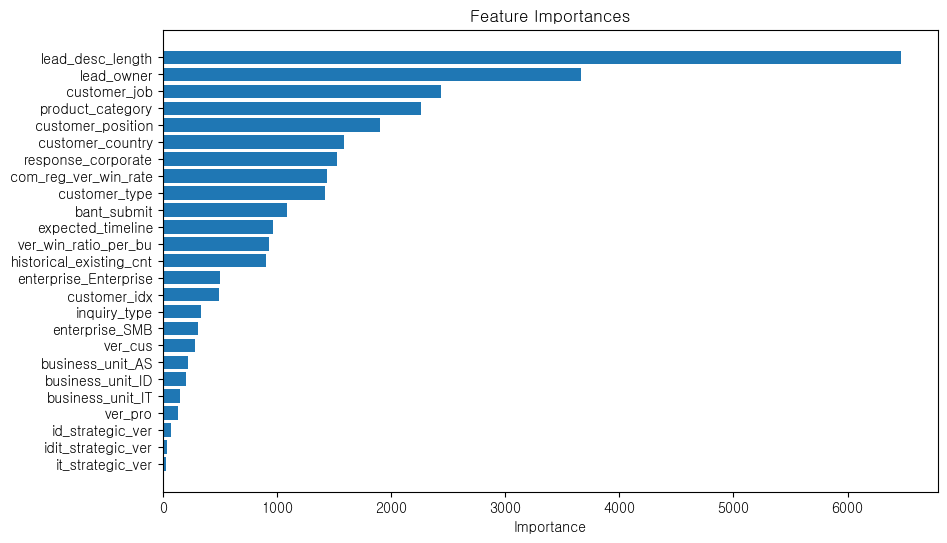

In [409]:
final_model = xgb.XGBClassifier(**study.best_trial.params)
final_model.fit(X_train_resampled, y_train_resampled)
y_pred_test = final_model.predict(test_data_feature)
# Get feature importances
# Get feature importances
feature_importances = final_model.get_booster().get_score(importance_type='weight')

# Prepare data for plotting
features = list(feature_importances.keys())
importances = list(feature_importances.values())
indices = range(len(importances))

# Sort the feature importances in descending order
sorted_idx = [i[0] for i in sorted(enumerate(importances), key=lambda x:x[1], reverse=True)]
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = [importances[i] for i in sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [416]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
y_pred_test_bool = np.where(y_pred_test == 1, True, False)
df_sub = pd.read_csv("../Database/submission.csv")
df_sub["is_converted"] = y_pred_test_bool
df_sub.to_csv("submission.csv", index=False)
df_sub["is_converted"].value_counts()

is_converted
False    3922
True     1349
Name: count, dtype: int64

In [264]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_reference = pd.read_csv("../Reference/submission_dt.csv")
df_reference["is_converted"].value_counts()

is_converted
False    4099
True     1172
Name: count, dtype: int64